In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston

%matplotlib inline

### Exploratory data analysis

In [2]:
boston = load_boston()

In [3]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['HomePrice'] = boston.target

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,HomePrice
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


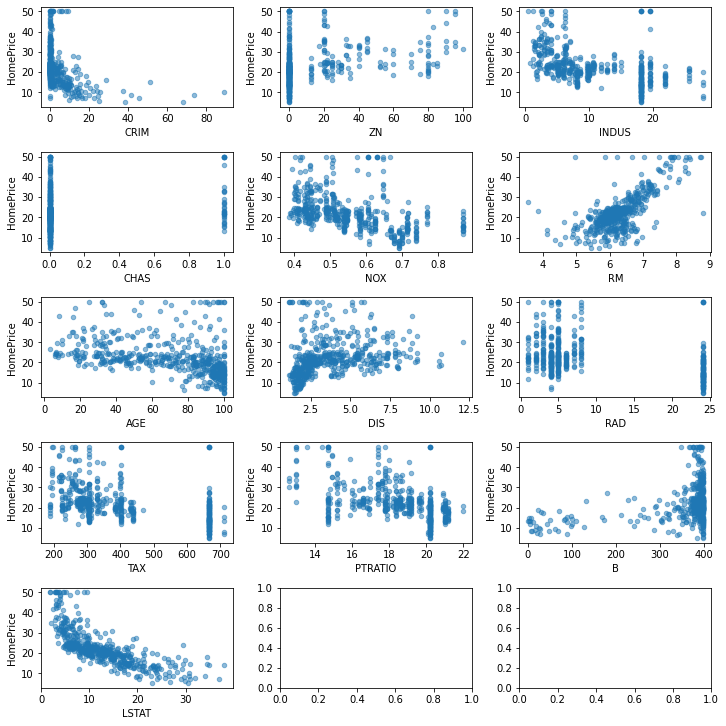

In [4]:
def scatterplotOfFeaturesVsTarget(df, featureNames, targetName, plotGrid=None):
    if not plotGrid:
        ncols = 3
        nrows = math.ceil(len(featureNames)/ncols)
    else:
        nrows, ncols = plotGrid    
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    axes = axes.reshape(-1, ncols) # Make sure axes is a 2D array  
    
    for k, col in enumerate(featureNames):
        i, j = divmod(k, ncols)
        ax = axes[i][j]
        df.plot.scatter(x=col, y=targetName, alpha=0.5, ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel(targetName)
        
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        


featureNames = boston.feature_names
targetName = 'HomePrice'
scatterplotOfFeaturesVsTarget(df, featureNames, targetName, plotGrid=None)

### Feature pipeline

In [5]:
from sklearn import base
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score, ShuffleSplit

In [6]:
class ColumnSelector(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]
    
    def get_feature_names(self):
        return self.columns.tolist()

In [7]:
class DerivedFeatures(base.BaseEstimator, base.TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        dfDerivedFeats = pd.DataFrame()
        dfDerivedFeats['INV_CRIM'] = 1./X['CRIM']
        dfDerivedFeats['INDUS7'] = X['INDUS'] <= 7.
        dfDerivedFeats['INDUS16'] = 1. * (X['INDUS'] <= 16.)
        dfDerivedFeats['INV_NOX'] = 1./X['NOX']
        dfDerivedFeats['AGE75'] = 1. * (X['AGE'] <= 76.)
        dfDerivedFeats['RAD5'] = 1. * (X['RAD'] <= 5.)
        dfDerivedFeats['TAX500'] = 1. * (X['TAX'] <= 500.)
        dfDerivedFeats['PTRATIO19'] = X['PTRATIO'] <= 19.
        dfDerivedFeats['B350'] = 1. * (X['B'] <= 350.)
        dfDerivedFeats['INV_LTSAT'] = 1. / X['LSTAT'] 
        
        self.featureNames = ['INV_CRIM', 'INDUS7', 'INDUS16', 'INV_NOX', 'AGE75', 
                             'RAD5', 'TAX500', 'PTRATIO19', 'B350', 'INV_LTSAT'
        ]
        
        return dfDerivedFeats
    
    
    def get_feature_names(self):
        return []    
    
    
#DerivedFeatures().fit_transform(df).head()    

In [8]:
originalFeatureNames = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
                        'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'
]

featureUnion = FeatureUnion([
    ('orig_feats', ColumnSelector(originalFeatureNames)),
    ('derived_feats', DerivedFeatures())
])

### Model: Linear Regression

In [9]:
model = Pipeline([
    ('feature_union', featureUnion),
    ('linReg', LinearRegression())
])

In [10]:
X = df[originalFeatureNames]
y = df['HomePrice']
model.fit(X, y)

Pipeline(steps=[('feature_union',
                 FeatureUnion(transformer_list=[('orig_feats',
                                                 ColumnSelector(columns=['CRIM',
                                                                         'ZN',
                                                                         'INDUS',
                                                                         'CHAS',
                                                                         'NOX',
                                                                         'RM',
                                                                         'AGE',
                                                                         'DIS',
                                                                         'RAD',
                                                                         'TAX',
                                                                         'PTRATIO',
                 

In [11]:
print ("R-squared: {:.2f}".format(model.score(X, y)))

R-squared: 0.80


In [12]:
def computeError(model, X, y):
    # Mean squared error
    cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=42)
    errors = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    #print (errors)
    return errors.mean()

In [13]:
print ("Mean squared error: {:.2f}".format(computeError(model, X, y)))

Mean squared error: 20.38
